# License Plate Detection Model

## Train YOLOv8 model on CCPD dataset

In [5]:
from ultralytics import YOLO

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
model = YOLO('yolov8s.pt')
model.train(data='config.yaml', epochs=25, batch=32, verbose=True)

## Model evaluation

In [6]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

training_results = pd.read_csv("runs/detect/train/results.csv")
list_column = [col.strip() for col in training_results.columns]
training_results.columns = list_column

### Training and Validation Loss

In [9]:
# Create Subplot
fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=["Localization Loss", "Classification Loss", "Distributional Focal Loss"], 
)

# Configuration Plot
class PlotCFG:
    marker_size = 6.5
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

loss_list = ["box_loss", "cls_loss", "dfl_loss"]
for i, loss in enumerate(loss_list):
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["train/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.train_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
            name="Training"
        ), row=1, col=i+1
    )
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["val/{}".format(loss)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=1, col=i+1
    )

# Update Axes
ticklabels = ["Box Loss", "Cls Loss", "DFL Loss"]
for i, ticklabel in enumerate(ticklabels):
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=i+1)
    fig.update_yaxes(title=ticklabel, linecolor="Black", ticks="outside", row=1, col=i+1)

# Update Layout
fig.update_layout(
    title="Training and Validation Loss", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=350,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

### Validation Metrics

In [19]:
# Create Subplot
subplot_titles = ["Precision", "Recall", "mAP50", "mAP50-95"]
fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=subplot_titles, 
)

# Configuration Plot
class PlotCFG:
    marker_size = 7
    line_size = 2
    train_color = "#1e3772"
    valid_color = "#2788f9"

metrics = ["precision", "recall", "mAP50", "mAP50-95"]
for i, metric in enumerate(metrics):
    # Plot
    fig.add_trace(
        go.Scatter(
            x=np.arange(1, training_results.shape[0]+1), y=training_results["metrics/{}(B)".format(metric)],
            mode="markers+lines",
            marker=dict(
                color=PlotCFG.valid_color, size=PlotCFG.marker_size, line=dict(color="White", width=0.5)
            ),
            line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
            name="Validation"
        ), row=(i//2)+1, col=(i%2)+1
    )
    
    # Update Axes
    fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)
    fig.update_yaxes(title=subplot_titles[i], linecolor="Black", ticks="outside", row=(i//2)+1, col=(i%2)+1)

# Update Layout
fig.update_layout(
    title="Validation Metrics", title_x=0.5, font_family="Trebuchet MS",
    width=950, height=600,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

### Testing

In [10]:
model = YOLO('best.pt')
metrics = model.val(data='config.yaml', split='test')

Ultralytics YOLOv8.0.221 🚀 Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning C:\Users\matss\Downloads\project\lp_detection_model\datasets\test.cache... 525 images, 0 backgrounds, 0 corrupt: 100%|██████████| 525/525 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:05<00:00,  5.89it/s]


                   all        525        525          1          1      0.995      0.702
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\val2


C:\Users\matss\AppData\Local\Temp\ipykernel_32856\1095135783.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


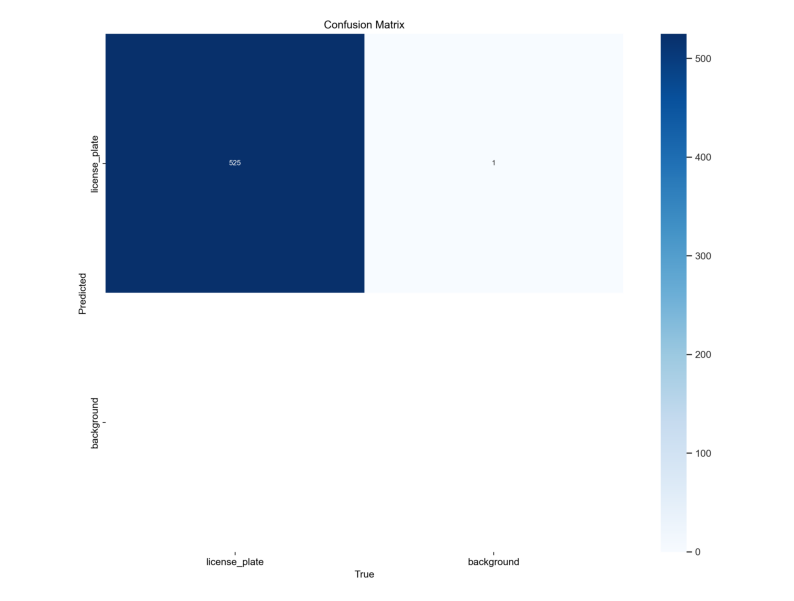

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"]="1"

# Confusion Matrix
fig = plt.figure(figsize=(10, 9))
cm_img = mpimg.imread("runs/detect/val/confusion_matrix.png")
plt.imshow(cm_img)
plt.axis("off")
fig.show()

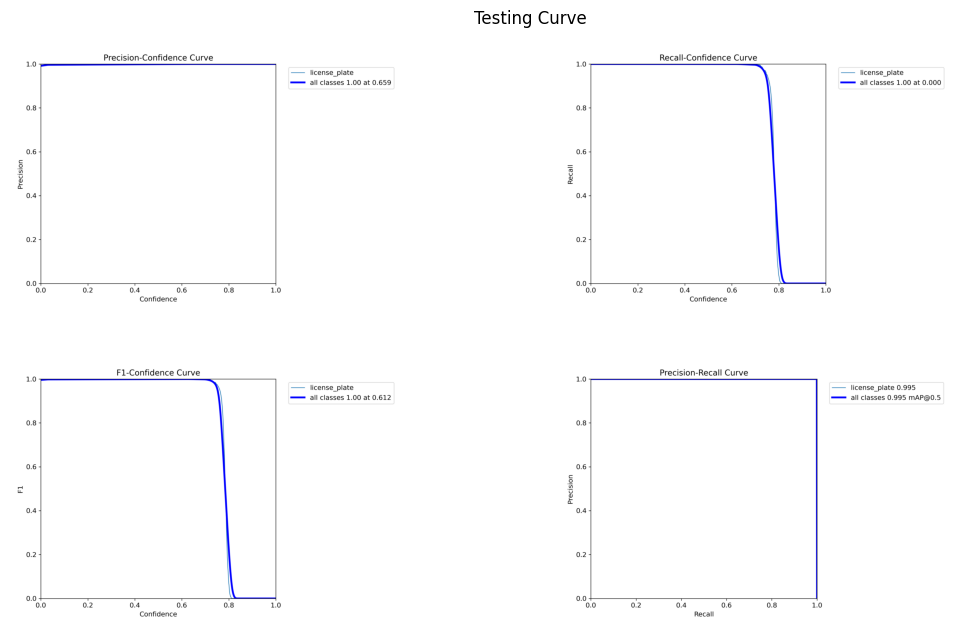

In [9]:
# Testing Curve
fig, axs = plt.subplots(2, 2, figsize=(13, 7.5))
curve_list = ["P_curve", "R_curve", "F1_curve", "PR_curve"]
for i, curve in enumerate(curve_list):
    curve_path = "runs/detect/val/{}.png".format(curve)
    curve_img = mpimg.imread(curve_path)
    axs[i//2, i%2].imshow(curve_img)
    axs[i//2, i%2].axis('off')
    
# Title
plt.suptitle("Testing Curve", x=0.55, y=0.93)

# Show
plt.show()